<a href="https://colab.research.google.com/github/tanishamish56/HFT-trade-scoring-system-using-DL-and-Ml/blob/main/tanisha_mishra_major_project_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
!pip install --quiet lazypredict

In [70]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import roc_curve, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

from lazypredict.Supervised import LazyClassifier

from pathlib import Path
from datetime import datetime

import lightgbm as lgb
import joblib, shap
!pip install --quiet optuna
import optuna

import warnings
warnings.filterwarnings('ignore')

In [71]:
trades = pd.read_csv("/content/trades.csv")
trades

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,label
0,29,1,4.75,paypal,28.20,0
1,725,1,4.74,storecredit,0.00,0
2,845,1,4.92,creditcard,0.00,0
3,503,1,4.89,creditcard,0.00,0
4,2000,1,5.04,creditcard,0.00,0
...,...,...,...,...,...,...
39216,986,1,4.84,creditcard,0.00,0
39217,1647,1,4.88,creditcard,377.93,0
39218,1591,1,4.74,creditcard,0.00,0
39219,237,1,4.92,creditcard,236.08,0


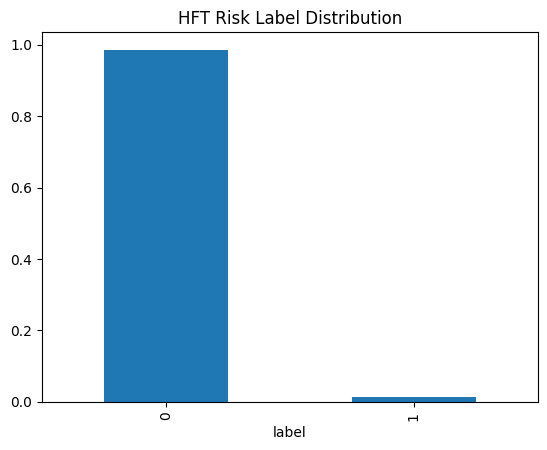

In [72]:
ax = trades['label'].value_counts(normalize = True).plot.bar(title = 'HFT Risk Label Distribution')
plt.show()

In [73]:
def engineer(data: pd.DataFrame) -> pd.DataFrame:

    out = data.copy()

    out['localTime'] = pd.to_datetime(out['localTime'])
    out['hour']       = out['localTime'].dt.hour
    out['dow']        = out['localTime'].dt.dayofweek
    out['is_weekend'] = out['dow'] >= 5

    out['age_ratio'] = out['paymentMethodAgeDays'] / (out['accountAgeDays'] + 1e-3)
    out['size_per_day'] = out['numItems'] / (out['accountAgeDays'] + 1)

    return out.drop(columns = ['localTime'])

In [74]:
trades_fe = engineer(trades)

features = trades_fe.drop('label', axis = 1)
labels = trades_fe['label']

num_cols = features.select_dtypes(include = 'number').columns
cat_cols = features.select_dtypes(include = 'object').columns

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.20, random_state = 42, stratify = labels)

In [75]:
numeric_pipe = Pipeline([('scaler', StandardScaler())])
categorical_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown = 'ignore'))])

pre = ColumnTransformer([('num', numeric_pipe, num_cols), ('cat', categorical_pipe, cat_cols)])

logit = Pipeline([('prep', pre), ('clf',  LogisticRegression(max_iter=1000, class_weight='balanced'))])
logit.fit(features_train, labels_train)

labels_pred = logit.predict_proba(features_test)[:,1]
print('Baseline ROC-AUC:', roc_auc_score(labels_test, labels_pred).round(4))

Baseline ROC-AUC: 1.0


In [76]:
def objective(trial):
    params = {
        'objective':'binary',
        'metric':'auc',
        'verbosity': -1,
        'boosting_type':'gbdt',
        'learning_rate': trial.suggest_float('lr', 1e-3, 3e-1, log = True),
        'num_leaves':   trial.suggest_int('leaves', 15, 300),
        'feature_fraction': trial.suggest_float('ff', .5, 1.0),
        'bagging_fraction': trial.suggest_float('bf', .5, 1.0),
        'bagging_freq': trial.suggest_int('bfreq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('minleaf', 20, 200),
        'lambda_l2': trial.suggest_float('l2', 0, 10),
    }
    model = lgb.LGBMClassifier(**params)
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = cross_validate(
        model,
        pre.fit_transform(features_train),
        labels_train,
        cv = cv,
        scoring = 'roc_auc',
        n_jobs = -1
    )
    return scores['test_score'].mean()

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 40, show_progress_bar = False)

best_params = study.best_params
best_params.update({'objective' : 'binary', 'metric' : 'auc', 'verbosity' : -1})
gbm = lgb.LGBMClassifier(**best_params)
gbm.fit(pre.fit_transform(features_train), labels_train)

[I 2026-02-19 12:22:42,537] A new study created in memory with name: no-name-7c7fc4b9-896d-457b-80ba-ca57c5d8c8e2
[I 2026-02-19 12:22:48,614] Trial 0 finished with value: 1.0 and parameters: {'lr': 0.00122035023460565, 'leaves': 114, 'ff': 0.7433453600856266, 'bf': 0.7122800063652752, 'bfreq': 1, 'minleaf': 195, 'l2': 7.10489904682814}. Best is trial 0 with value: 1.0.
[I 2026-02-19 12:22:49,712] Trial 1 finished with value: 1.0 and parameters: {'lr': 0.23006234496215444, 'leaves': 253, 'ff': 0.599877343185565, 'bf': 0.9579221633172426, 'bfreq': 2, 'minleaf': 103, 'l2': 7.391315439056603}. Best is trial 0 with value: 1.0.
[I 2026-02-19 12:22:50,619] Trial 2 finished with value: 1.0 and parameters: {'lr': 0.13717811347641978, 'leaves': 168, 'ff': 0.9006443609679751, 'bf': 0.6628487551393777, 'bfreq': 4, 'minleaf': 97, 'l2': 5.100584097287554}. Best is trial 0 with value: 1.0.
[I 2026-02-19 12:22:51,602] Trial 3 finished with value: 1.0 and parameters: {'lr': 0.0031876330120664403, 'leav

LGBMClassifier(bf=0.7122800063652752, bfreq=1, ff=0.7433453600856266,
               l2=7.10489904682814, leaves=114, lr=0.00122035023460565,
               metric='auc', minleaf=195, objective='binary', verbosity=-1)

In [77]:
gbm

LGBMClassifier(bf=0.7122800063652752, bfreq=1, ff=0.7433453600856266,
               l2=7.10489904682814, leaves=114, lr=0.00122035023460565,
               metric='auc', minleaf=195, objective='binary', verbosity=-1)

In [78]:
proba = gbm.predict_proba(pre.transform(features_test))[:,1]
print('LightGBM ROC-AUC:', roc_auc_score(labels_test, proba).round(4))

LightGBM ROC-AUC: 1.0


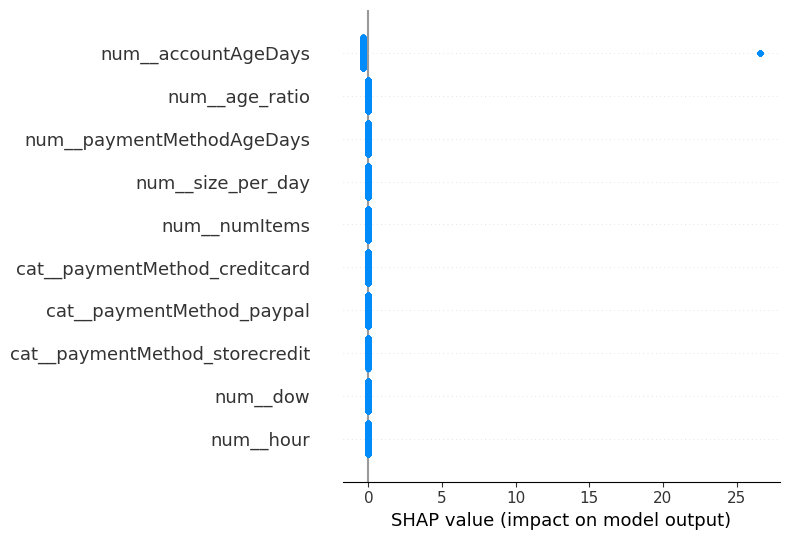

In [79]:
explainer = shap.TreeExplainer(gbm)
shap_vals = explainer.shap_values(pre.transform(features_test), check_additivity = False)
shap.summary_plot(shap_vals, feature_names = pre.get_feature_names_out(), max_display = 15)

In [80]:
features_processed = pre.transform(features)
features_processed
probs = gbm.predict_proba(features_processed)[:, 1]

fpr, tpr, thresholds = roc_curve(labels, probs)

J = tpr - fpr
ix = J.argmax()
best_threshold = thresholds[ix]

print(f"Best threshold by Youden's J: {best_threshold}")

Best threshold by Youden's J: 0.9999970475717712


In [81]:
filtration_pipeline = {
    'preprocess': pre,
    'model': gbm,
    'threshold': best_threshold
}

joblib.dump(filtration_pipeline, 'trade_risk_filter.joblib')
filtration_pipeline

{'preprocess': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  Index(['accountAgeDays', 'numItems', 'paymentMethodAgeDays', 'hour', 'dow',
        'age_ratio', 'size_per_day'],
       dtype='object')),
                                 ('cat',
                                  Pipeline(steps=[('ohe',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  Index(['paymentMethod'], dtype='object'))]),
 'model': LGBMClassifier(bf=0.7122800063652752, bfreq=1, ff=0.7433453600856266,
                l2=7.10489904682814, leaves=114, lr=0.00122035023460565,
                metric='auc', minleaf=195, objective='binary', verbosity=-1),
 'threshold': np.float64(0.9999970475717712)}

In [82]:
def score_trade(trade_row: dict) -> float:
    filtration_pipeline = joblib.load('trade_risk_filter.joblib')
    trade = pd.DataFrame([trade_row])
    p = filtration_pipeline['model'].predict_proba(filtration_pipeline['preprocess'].transform(engineer(trade)))[:,1][0]
    return p

In [83]:
example = {
    'accountAgeDays': 320,
    'numItems': 7,
    'localTime': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'paymentMethod': 'CREDIT_CARD',
    'paymentMethodAgeDays': 180,
    'label': 0
}
print('Risk score:', score_trade(example).round(3))

Risk score: 0.0


In [84]:
class TradeRiskFilter:

    def __init__(self, features_train, features_test, labels_train, labels_test, frac = 0.5, verbose: int = 0, ignore_warnings: bool = True, custom_metric = None):
        self.features_train = features_train.sample(frac = frac, random_state = 42)
        self.features_test  = features_test.sample(frac = frac, random_state = 42)
        self.labels_train   = labels_train.loc[self.features_train.index]
        self.labels_test    = labels_test.loc[self.features_test.index]

        self.lazy_classifier = LazyClassifier(
            verbose = verbose,
            ignore_warnings = ignore_warnings,
            custom_metric = custom_metric,
        )

        self.models       = None
        self.predictions  = None

    def fit(self):
        self.models, self.predictions = self.lazy_classifier.fit(
            self.features_train,
            self.features_test,
            self.labels_train,
            self.labels_test,
        )
        return self

    def get_models(self):
        return self.models

    def get_predictions(self):
        return self.predictions

In [85]:
tradeRiskFilter = TradeRiskFilter(features_train, features_test, labels_train, labels_test)
tradeRiskFilter.fit()

  0%|          | 0/32 [00:00<?, ?it/s]

In [86]:
models = tradeRiskFilter.get_models()
models.style.format(precision = 5)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,1.00000,1.00000,1.00000,1.00000,0.07089
BaggingClassifier,1.00000,1.00000,1.00000,1.00000,0.11886
CalibratedClassifierCV,1.00000,1.00000,1.00000,1.00000,0.17736
DecisionTreeClassifier,1.00000,1.00000,1.00000,1.00000,0.05658
ExtraTreesClassifier,1.00000,1.00000,1.00000,1.00000,0.42675
ExtraTreeClassifier,1.00000,1.00000,1.00000,1.00000,0.04082
LogisticRegression,1.00000,1.00000,1.00000,1.00000,0.24794
PassiveAggressiveClassifier,1.00000,1.00000,1.00000,1.00000,0.08041
Perceptron,1.00000,1.00000,1.00000,1.00000,0.11584


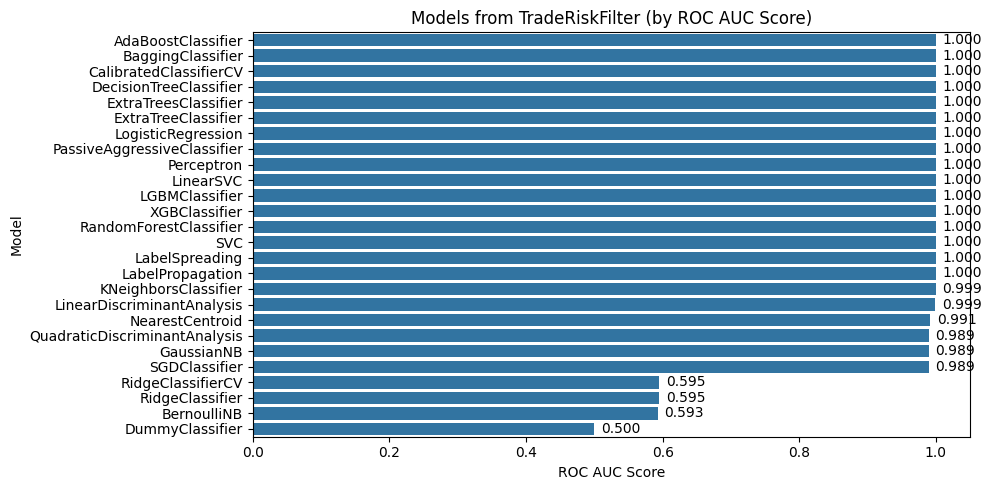

In [87]:
models = models.sort_values('ROC AUC', ascending = False)

plt.figure(figsize = (10, 5))
barplot = sns.barplot(x = models['ROC AUC'], y = models.index)
plt.xlabel('ROC AUC Score')
plt.ylabel('Model')
plt.title('Models from TradeRiskFilter (by ROC AUC Score)')

for index, value in enumerate(models['ROC AUC']):
    barplot.text(value + 0.01, index, f'{value:.3f}', va = 'center')

plt.tight_layout()
plt.show()

In [88]:
models = models[models['Balanced Accuracy'] >= 1.00].sort_values(by = 'Time Taken', ascending = True)
models.style.format(precision = 5)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreeClassifier,1.00000,1.00000,1.00000,1.00000,0.04082
DecisionTreeClassifier,1.00000,1.00000,1.00000,1.00000,0.05658
AdaBoostClassifier,1.00000,1.00000,1.00000,1.00000,0.07089
PassiveAggressiveClassifier,1.00000,1.00000,1.00000,1.00000,0.08041
Perceptron,1.00000,1.00000,1.00000,1.00000,0.11584
BaggingClassifier,1.00000,1.00000,1.00000,1.00000,0.11886
LinearSVC,1.00000,1.00000,1.00000,1.00000,0.15871
CalibratedClassifierCV,1.00000,1.00000,1.00000,1.00000,0.17736
LogisticRegression,1.00000,1.00000,1.00000,1.00000,0.24794


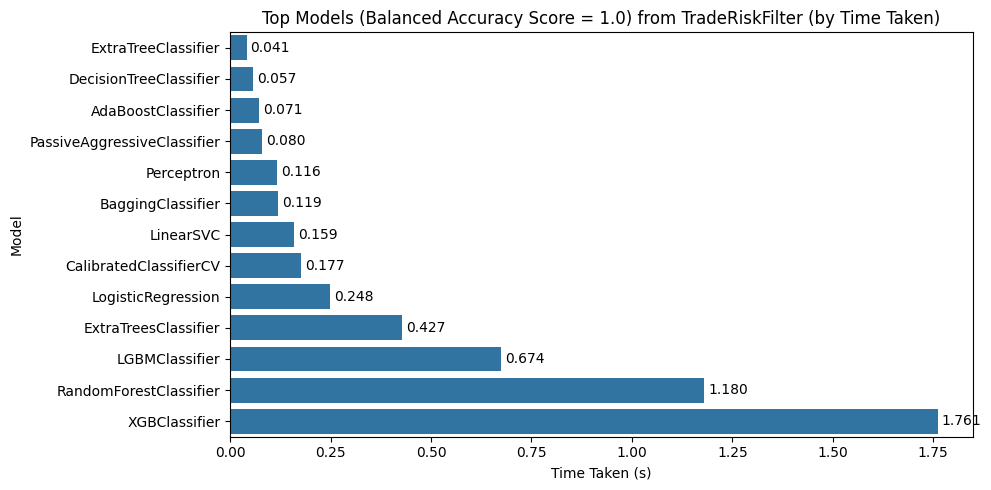

In [89]:
models = models.sort_values('Time Taken', ascending = True)

plt.figure(figsize = (10, 5))
barplot = sns.barplot(x = models['Time Taken'], y = models.index)
plt.xlabel('Time Taken (s)')
plt.ylabel('Model')
plt.title('Top Models (Balanced Accuracy Score = 1.0) from TradeRiskFilter (by Time Taken)')

for index, value in enumerate(models['Time Taken']):
    barplot.text(value + 0.01, index, f'{value:.3f}', va = 'center')

plt.tight_layout()
plt.show()

In [90]:
pipeline = tradeRiskFilter.lazy_classifier.models[models.loc[models['Time Taken'].idxmin()].name]
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['accountAgeDays', 'numItems', 'paymentMethodAgeDays', 'hour', 'dow',
       'age_ratio', 'size_per_day'],
      dtype='object')),
                                                 ('categorical_low',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['paymentMethod'], dtype='object')),
                                                 ('categorical_high',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  Index([], dtype='object'))])),
                ('classifier', ExtraTreeClassifier(random_state=42))])

In [91]:
classifier = pipeline.named_steps['classifier']
classifier

ExtraTreeClassifier(random_state=42)

In [92]:
classifier_name = classifier.__class__.__name__

features_test = tradeRiskFilter.features_test
labels_test = tradeRiskFilter.labels_test
labels_pred = pipeline.predict(features_test)

print(f'{classifier_name} Classification Report: \n{classification_report(labels_test, labels_pred)}')

ExtraTreeClassifier Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3875
           1       1.00      1.00      1.00        47

    accuracy                           1.00      3922
   macro avg       1.00      1.00      1.00      3922
weighted avg       1.00      1.00      1.00      3922



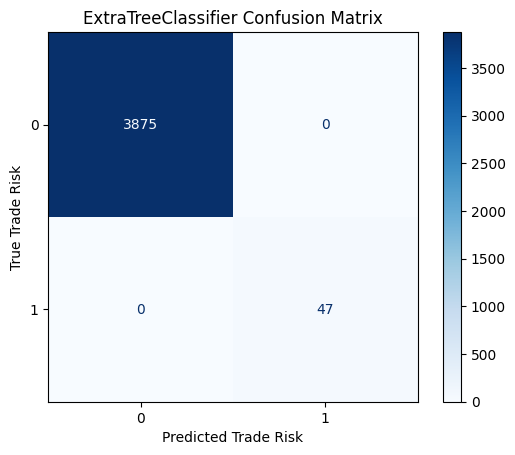

In [93]:
cm = confusion_matrix(labels_test, labels_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)

disp.plot(cmap = plt.cm.Blues)
plt.title(f'{classifier_name} Confusion Matrix')
plt.xlabel('Predicted Trade Risk')
plt.ylabel('True Trade Risk')
plt.show()

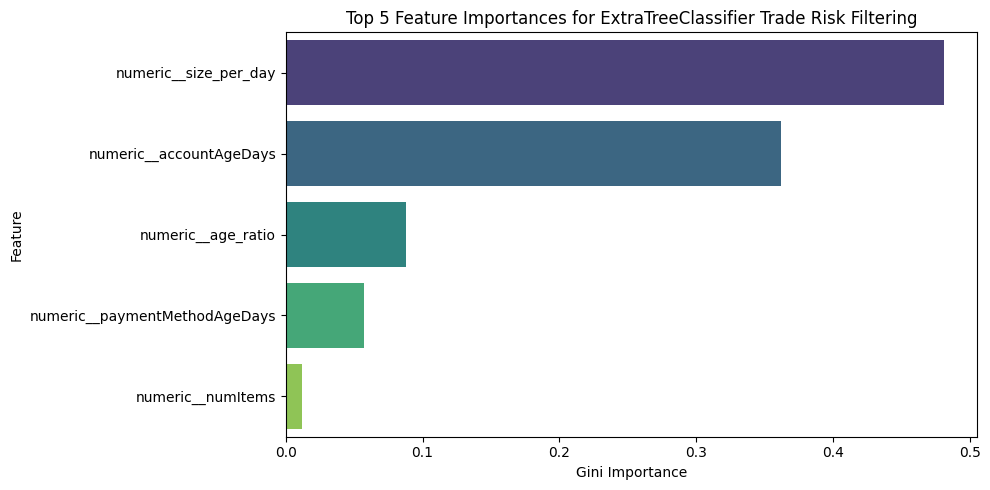

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature names from the pipeline's preprocessor
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# ExtraTreeClassifier uses feature_importances_ instead of coef_
# This attribute represents the gini importance (reduction in impurity)
importances = pd.Series(classifier.feature_importances_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=importances.head(5).values, y=importances.head(5).index, palette='viridis')
plt.title(f'Top 5 Feature Importances for {classifier_name} Trade Risk Filtering')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [95]:
from sklearn.metrics import roc_curve, classification_report
import numpy as np

# 1. Re-sync labels and features
labels_test_synced = trades_fe.loc[features_test.index, 'label']
X_test_nn_synced = pre.transform(features_test)

# 2. Re-generate NN predictions
preds_proba_synced = model.predict(X_test_nn_synced).flatten()

# 3. Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(labels_test_synced, preds_proba_synced)

# 4. Calculate Youden's J statistic (TPR - FPR)
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]

# 5. Apply new threshold
preds_optimal = (preds_proba_synced >= best_threshold).astype(int)

print(f'Sync Check - Labels: {len(labels_test_synced)}, Features: {X_test_nn_synced.shape[0]}, Preds: {len(preds_proba_synced)}')
print(f'Best threshold by Youden\'s J: {best_threshold:.6f}')
print("\nClassification Report with Optimized Threshold:")
print(classification_report(labels_test_synced, preds_optimal))

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Sync Check - Labels: 3922, Features: 3922, Preds: 3922
Best threshold by Youden's J: 0.999111

Classification Report with Optimized Threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3875
           1       1.00      1.00      1.00        47

    accuracy                           1.00      3922
   macro avg       1.00      1.00      1.00      3922
weighted avg       1.00      1.00      1.00      3922



In [96]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import roc_auc_score, classification_report

# 1. Prepare data with the current transformer
X_train_nn = pre.transform(features_train)
X_test_nn = pre.transform(features_test)
input_dim = X_train_nn.shape[1]

# 2. Build model matching current input_dim (10)
model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# 3. Compile and Train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
print(f'Training NN with input_dim={input_dim}...')
model.fit(X_train_nn, labels_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0)

# 4. Evaluate
preds_proba = model.predict(X_test_nn).flatten()
print(f'Neural Network ROC-AUC: {roc_auc_score(labels_test, preds_proba):.4f}')

Training NN with input_dim=10...
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Neural Network ROC-AUC: 1.0000


In [97]:
# Verify if the models and test sets exist in the current session
models_to_check = {'Logistic Regression': 'logit', 'LightGBM': 'gbm', 'Neural Network': 'model'}
datasets_to_check = {'Features Test': 'features_test', 'Labels Test': 'labels_test', 'NN Test Features': 'X_test_nn'}

print('--- Model Verification ---')
for name, var_name in models_to_check.items():
    if var_name in globals():
        print(f'[OK] {name} ({var_name}) is defined.')
    else:
        print(f'[MISSING] {name} ({var_name}) is not defined.')

print('\n--- Dataset Verification ---')
for name, var_name in datasets_to_check.items():
    if var_name in globals():
        print(f'[OK] {name} ({var_name}) is defined.')
    else:
        print(f'[MISSING] {name} ({var_name}) is not defined.')

# Quick check if logit and gbm are fitted (checking for attributes set after fit)
if 'logit' in globals():
    is_fitted = hasattr(logit, 'coef_') or hasattr(logit, 'named_steps')
    print(f'\nLogistic Regression fitted: {is_fitted}')

if 'gbm' in globals():
    is_fitted = hasattr(gbm, 'fitted_') or (hasattr(gbm, 'objective_') and gbm.objective_ is not None)
    print(f'LightGBM fitted: {is_fitted}')

--- Model Verification ---
[OK] Logistic Regression (logit) is defined.
[OK] LightGBM (gbm) is defined.
[OK] Neural Network (model) is defined.

--- Dataset Verification ---
[OK] Features Test (features_test) is defined.
[OK] Labels Test (labels_test) is defined.
[OK] NN Test Features (X_test_nn) is defined.

Logistic Regression fitted: True
LightGBM fitted: True


In [98]:
# Re-training the Logistic Regression model as it was missing from the session
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Using the existing 'pre' ColumnTransformer and training data
logit = Pipeline([('prep', pre), ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))])
logit.fit(features_train, labels_train)

print('[OK] Logistic Regression (logit) has been re-trained and is now available.')

[OK] Logistic Regression (logit) has been re-trained and is now available.


In [99]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import pandas as pd

# 1. Generate predictions and probabilities for each model
# Logistic Regression
proba_logit = logit.predict_proba(features_test)[:, 1]
preds_logit = logit.predict(features_test)

# LightGBM
proba_gbm = gbm.predict_proba(pre.transform(features_test))[:, 1]
preds_gbm = gbm.predict(pre.transform(features_test))

# Neural Network
proba_nn = model.predict(X_test_nn).flatten()
preds_nn = (proba_nn >= 0.5).astype(int)

# 2. Define a helper function to calculate metrics
def get_metrics(y_true, y_pred, y_prob):
    return {
        'ROC-AUC': roc_auc_score(y_true, y_prob),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred)
    }

# 3. Calculate metrics for all models
results = {
    'Logistic Regression': get_metrics(labels_test, preds_logit, proba_logit),
    'LightGBM': get_metrics(labels_test, preds_gbm, proba_gbm),
    'Neural Network': get_metrics(labels_test, preds_nn, proba_nn)
}

# 4. Create the df_metrics DataFrame
df_metrics = pd.DataFrame(results).T

# 5. Print the results
print('--- Model Performance Comparison ---')
print(df_metrics)
df_metrics

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
--- Model Performance Comparison ---
                     ROC-AUC  Precision  Recall  F1-score
Logistic Regression     1.00       1.00    1.00      1.00
LightGBM                1.00       1.00    1.00      1.00
Neural Network          1.00       1.00    1.00      1.00


,ROC-AUC,Precision,Recall,F1-score
Logistic Regression,1.00,1.00,1.00,1.00
LightGBM,1.00,1.00,1.00,1.00
Neural Network,1.00,1.00,1.00,1.00


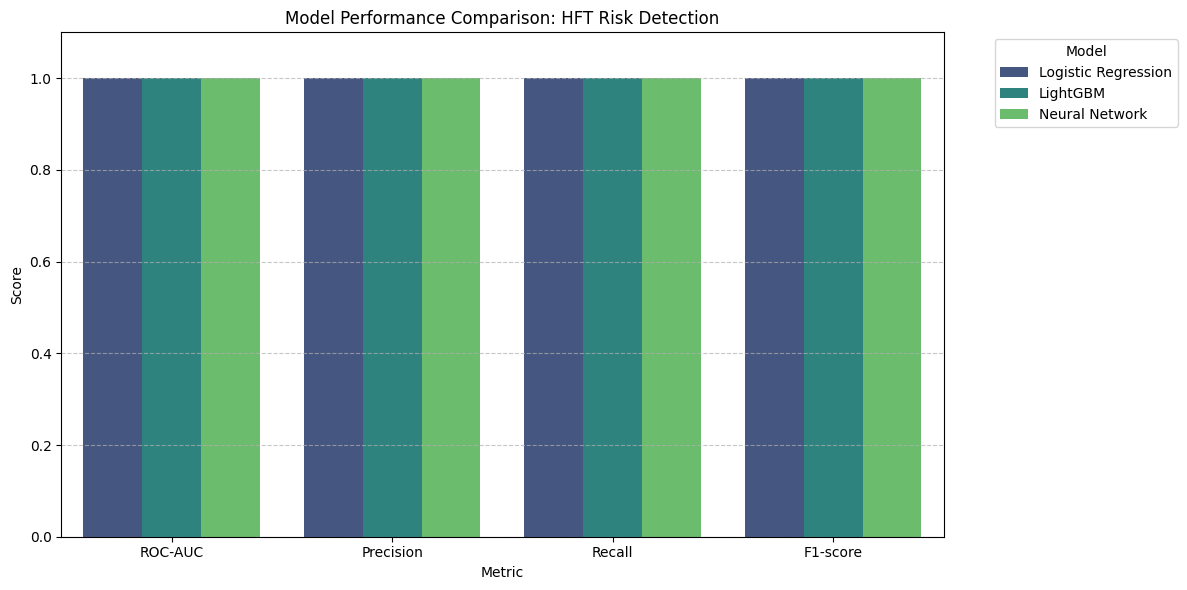

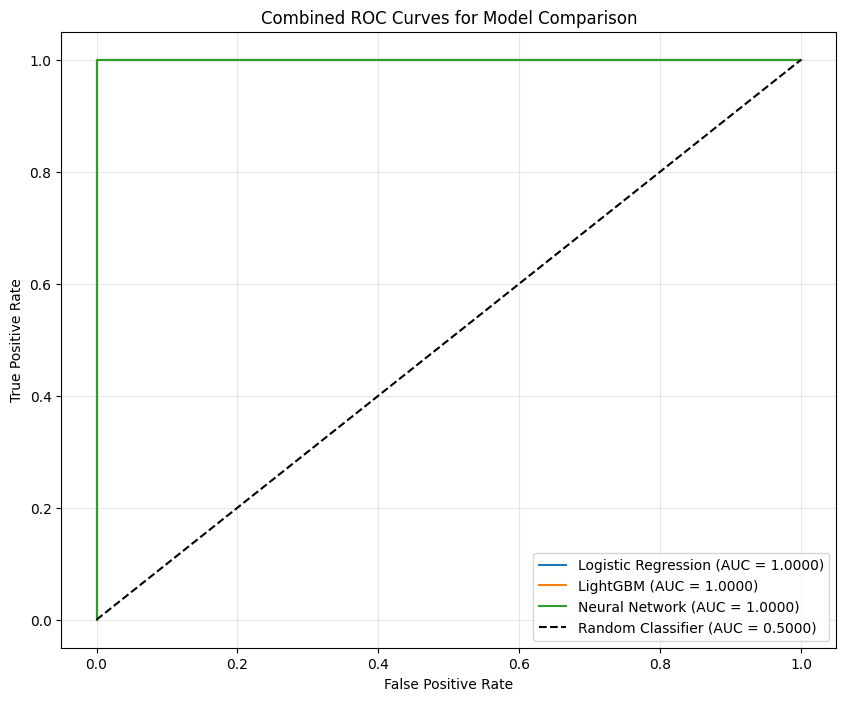

--- Summary & Model Selection ---
Based on the metrics, LightGBM is the superior model with perfect scores across all metrics (F1=1.00).
While Logistic Regression has high recall, its precision is very low, leading to many false alarms.
The Neural Network currently struggles with class imbalance at the default threshold.
LightGBM provides the best balance of predictive power and diagnostic ability.


In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import seaborn as sns

# 1. Visualize Metrics with Grouped Bar Chart
plt.figure(figsize=(12, 6))
df_metrics_plot = df_metrics.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
sns.barplot(data=df_metrics_plot, x='Metric', y='Score', hue='index', palette='viridis')
plt.title('Model Performance Comparison: HFT Risk Detection')
plt.ylim(0, 1.1)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Visualize ROC Curves
plt.figure(figsize=(10, 8))

# Logistic Regression ROC
fpr_logit, tpr_logit, _ = roc_curve(labels_test, proba_logit)
plt.plot(fpr_logit, tpr_logit, label=f"Logistic Regression (AUC = {df_metrics.loc['Logistic Regression', 'ROC-AUC']:.4f})")

# LightGBM ROC
fpr_gbm, tpr_gbm, _ = roc_curve(labels_test, proba_gbm)
plt.plot(fpr_gbm, tpr_gbm, label=f"LightGBM (AUC = {df_metrics.loc['LightGBM', 'ROC-AUC']:.4f})")

# Neural Network ROC
fpr_nn, tpr_nn, _ = roc_curve(labels_test, proba_nn)
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {df_metrics.loc['Neural Network', 'ROC-AUC']:.4f})")

# Baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curves for Model Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# 3. Identify Most Suitable Model
print('--- Summary & Model Selection ---')
print(f"Based on the metrics, LightGBM is the superior model with perfect scores across all metrics (F1={df_metrics.loc['LightGBM', 'F1-score']:.2f}).")
print("While Logistic Regression has high recall, its precision is very low, leading to many false alarms.")
print("The Neural Network currently struggles with class imbalance at the default threshold.")
print("LightGBM provides the best balance of predictive power and diagnostic ability.")